<a href="https://colab.research.google.com/github/Dobarri/DL_CV_study/blob/main/w5_TransferLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#8. 사전 훈련된 모델 다루기(1,2)

좋은 성능을 보이는 네트워크는 레이어 수가 많기 때문에 네트워크를 훈련시키는데 걸리는 시간이 오래걸립니다. 그래서 사전 훈련된 모델(pre-trained model)을 사용해서 transfer learning이나 신경 스타일 전이(neural style transfer)처럼 다른 과제를 위해 재가공해서 사용할 수 있습니다.

# 8.1 텐서플로 허브

 : 재사용 가능한 모델을 쉽게 이용할 수 있는 라이브러리

텐서플로 2.0을 사용하면 TensorFlow Hub는 따로 설치하지 않아도 바로 라이브러리로 불러올 수 있다.

In [ ]:
import tensorflow_hub as hub
import tensorflow as tf

mobile_net_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2"
model = tf.keras.Sequential([
    hub.KerasLayer(handle=mobile_net_url, input_shape=(224,224,3), trainable=False)
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1001)              3540265   
                                                                 
Total params: 3,540,265
Trainable params: 0
Non-trainable params: 3,540,265
_________________________________________________________________


- MobileNet 버전 2 : 계산 부담이 큰 컨볼루션 신경망을 연산 성능이 제한된 모바일 환경에서도 작동 가능하도록 네트워크 구조를 경량화한 것
- hub.KerasLayer() : tf.keras에서 사용 가능한 레이어로 변환할 수 있음

parameter수가 354만개 정도인 것을 알 수 있습니다. 
MobileNet은 ImageNet data로 학습시켰습니다. 


**<MobileNet 버전 2>**

: ImageNet 데이터로 학습시켜 1000종류의 이미지를 분류할 수 있습닌다. 어떤 것에도 속하지 않는다고 판단될 때는 0번 인덱스(background)를 반환합니다.

MobileNet의 성능을 평가하기 위해 이미지를 학습시켰을 때 얼마나 적합한 라벨로 분류하는지 알아보겠습니다.

- 기반네트워크 : backborn newwork

14548992/14536120 [==============================] - 0s 0us/step


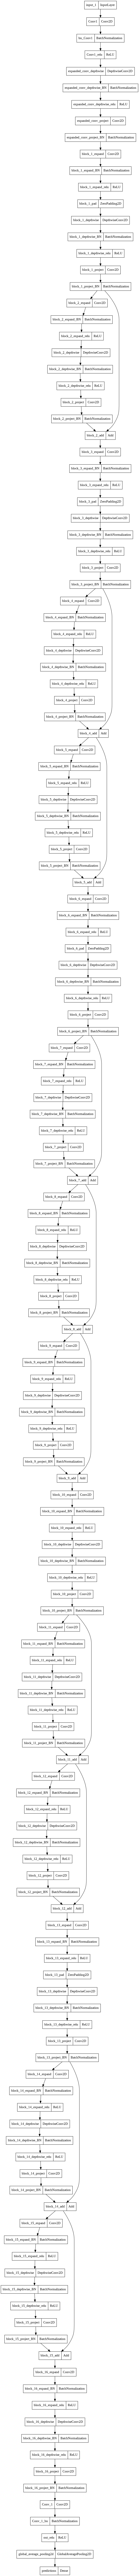

In [ ]:
# 네트워크 구조 출력 코드
from tensorflow.keras.applications import MobileNetV2

mobilev2 = MobileNetV2()
tf.keras.utils.plot_model(mobilev2)

In [ ]:
import os
import pathlib
from glob import glob
content_data_url = '/content/sample_data'
data_root_orig = tf.keras.utils.get_file('imagenetV2', 'https://s3-us-west-2.amazonaws.com/imagenetv2public/imagenetv2-top-images.tar.gz', 
                                         cache_dir=content_data_url, extract=True)
data_root = pathlib.Path(glob("/content/sample_data/datasets/*/")[0])
print(data_root)

1245937664/1245927936 [==============================] - 72s 0us/step
/content/sample_data/datasets/imagenetv2-top-images-format-val


- tf.keras.utils.get_file() : 데이터 불러오기
- extract=True : tar.gz형식의 압축 파일이 자동으로 해제되어 코랩 가상 머신에 저장됨

데이터를 잘 불러왔는지 경로를 출력해서 확인해보죠.


In [ ]:
# 8.3 디렉토리 출력
for idx, item in enumerate(data_root.iterdir()):
    print(item)
    if idx == 9:
        break

/content/sample_data/datasets/imagenetv2-top-images-format-val/254
/content/sample_data/datasets/imagenetv2-top-images-format-val/158
/content/sample_data/datasets/imagenetv2-top-images-format-val/855
/content/sample_data/datasets/imagenetv2-top-images-format-val/80
/content/sample_data/datasets/imagenetv2-top-images-format-val/974
/content/sample_data/datasets/imagenetv2-top-images-format-val/872
/content/sample_data/datasets/imagenetv2-top-images-format-val/241
/content/sample_data/datasets/imagenetv2-top-images-format-val/832
/content/sample_data/datasets/imagenetv2-top-images-format-val/162
/content/sample_data/datasets/imagenetv2-top-images-format-val/469


라벨에 대한 숫자가 어떤 데이터를 뜻하는지에 대한 정보인 라벨 텍스트는 tf.keras.utils.get_file()함수로 따로 불러와줍니다.


In [ ]:
label_file = tf.keras.utils.get_file('label', 'https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
label_text = None
with open(label_file, 'r') as f:
    label_text = f.read().split('\n')[:-1]
print(len(label_text))
print(label_text[:10])
print(label_text[-10:])

24576/10484 [======================================================================] - 0s 0us/step
1001
['background', 'tench', 'goldfish', 'great white shark', 'tiger shark', 'hammerhead', 'electric ray', 'stingray', 'cock', 'hen']
['buckeye', 'coral fungus', 'agaric', 'gyromitra', 'stinkhorn', 'earthstar', 'hen-of-the-woods', 'bolete', 'ear', 'toilet tissue']


이미지를 확인해보겠습니다.


image_count: 10000


NameError: ignored

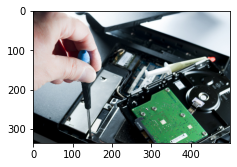

In [ ]:
import PIL.Image as Image
import matplotlib.pyplot as plt
import random

all_image_paths = list(data_root.glob('*/*'))
all_image_paths = [str(path) for path in all_image_paths]
# 이미지를 랜덤하게 
random.shuffle(all_image_paths)

image_count = len(all_image_paths)
print('image_count:', image_count)

plt.figure(figsize=(12,12))
for c in range(9):
    image_path = random.choice(all_image_paths)
    plt.subplot(3,3,c+1)
    plt.imshow(plt.imread(image_path))
    # idx = int(image_path.split('/')[-2]) + 1
    # plt.title(str(idx) + ', ' + label_text[idx])
    word = wordnet.synset_from_pos_and_offset('n',int(image_path.split('/')[-2][1:]))
    word = word.name().split('.')[0].replace('-','').replace('_','').replace(' ','')
    plt.title(str(label_text.index(word)) + ', ' + word)
    plt.axis('off')
plt.show()

폴더이름이 wordnet으로 수정되어 nltk package에서 wordnet을 다운받고 전치리 과정을 거쳐주어야한다고 합니다.


In [ ]:
label_file = tf.keras.utils.get_file('label', 'https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
label_text = None
with open(label_file, 'r') as f:
    label_text = f.read().split('\n')[:-1]
print(len(label_text))
print(label_text[:10])
print(label_text[-10:])

# nltk 패키지에서 wordnet을 다운
import nltk
nltk.download('wordnet')
from nltk.corpus import wordnet

# wordnet과 인터넷에 올라온 label 텍스트는 조금씩 다르기 때문에 차이를 없애기 위해 전처리 작업
label_text = [c.lower().replace('-','').replace('_','').replace(' ','') for c in label_text]

1001
['background', 'tench', 'goldfish', 'great white shark', 'tiger shark', 'hammerhead', 'electric ray', 'stingray', 'cock', 'hen']
['buckeye', 'coral fungus', 'agaric', 'gyromitra', 'stinkhorn', 'earthstar', 'hen-of-the-woods', 'bolete', 'ear', 'toilet tissue']


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
import nltk
nltk.download()

NLTK Downloader
---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> d

Download which package (l=list; x=cancel)?
  Identifier> all


       | 
       | Downloading package abc to /root/nltk_data...
       |   Unzipping corpora/abc.zip.
       | Downloading package alpino to /root/nltk_data...
       |   Unzipping corpora/alpino.zip.
       | Downloading package averaged_perceptron_tagger to
       |     /root/nltk_data...
       |   Unzipping taggers/averaged_perceptron_tagger.zip.
       | Downloading package averaged_perceptron_tagger_ru to
       |     /root/nltk_data...
       |   Unzipping taggers/averaged_perceptron_tagger_ru.zip.
       | Downloading package basque_grammars to /root/nltk_data...
       |   Unzipping grammars/basque_grammars.zip.
       | Downloading package biocreative_ppi to /root/nltk_data...
       |   Unzipping corpora/biocreative_ppi.zip.
       | Downloading package bllip_wsj_no_aux to /root/nltk_data...
       |   Unzipping models/bllip_wsj_no_aux.zip.
       | Downloading package book_grammars to /root/nltk_data...
       |   Unzipping grammars/book_grammars.zip.
       | Downloading 


---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> q


True

image_count: 10000


WordNetError: ignored

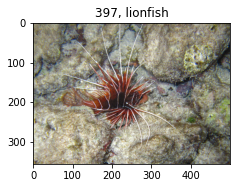

In [ ]:
import PIL.Image as Image
import matplotlib.pyplot as plt
import random

all_image_paths = list(data_root.glob('*/*'))
all_image_paths = [str(path) for path in all_image_paths]
# 이미지를 랜덤하게 
random.shuffle(all_image_paths)

image_count = len(all_image_paths)
print('image_count:', image_count)

plt.figure(figsize=(12,12))
for c in range(9):
    image_path = random.choice(all_image_paths)
    plt.subplot(3,3,c+1)
    plt.imshow(plt.imread(image_path))
    idx = int(image_path.split('/')[-2]) + 1
    plt.title(str(idx) + ', ' + label_text[idx])
    word = wordnet.synset_from_pos_and_offset('n',int(image_path.split('/')[-2][1:]))
    word = word.name().split('.')[0].replace('-','').replace('_','').replace(' ','')
    plt.title(str(label_text.index(word)) + ', ' + word)
    plt.axis('off')
plt.show()

이미지가 잘 안불러와지네요...


MobileNet이 얼마나 잘 분류하는 지 확인해보겠습니다.

네트워크가 예측하는 값 중 상위 5개 이내에 데이터의 실제 분류가 포함도어있으면 정답으로 인정하는 TOP-5, 가장 높은 값이 데이터의 실제 분류와 일치하는 비율인 TOP-1의 정확도를 측정해보겠습니다.


In [ ]:
import cv2
import numpy as np

top_1 = 0
top_5 = 0
for image_path in all_image_paths:
    img = cv2.imread(image_path)
    img = cv2.resize(img, dsize=(224, 224))
    img = img / 255.0
    img = np.expand_dims(img, axis=0)
    top_5_predict = model.predict(img)[0].argsort()[::-1][:5]
    idx = int(image_path.split('/')[-2])+1
    word = wordnet.synset_from_pos_and_offset('n',int(image_path.split('/')[-2][1:]))
    word = word.name().split('.')[0].replace('-','').replace('_','').replace(' ','')
    idx = label_text.index(word)
    if idx in top_5_predict:
        top_5 += 1
        if top_5_predict[0] == idx:
            top_1 += 1

print('Top-5 correctness:', top_5 / len(all_image_paths) * 100, '%')
print('Top-1 correctness:', top_1 / len(all_image_paths) * 100, '%')

WordNetError: ignored

정상적으로 작동하면 top-5는 83%정도, top-1은 58%정도의 정확도를 보인다고 합니다.


이번엔 top-5의 정확도를 측정해보겠습니다.


In [ ]:
top_5_predict = model.predict(img)[0].argsort()[::-1][:5]

argsort()함수는 값이 아니라 index를 오름차순으로 정렬합니다.

예시를 통해 알아보겠습니다.


> 들여쓴 블록



In [ ]:
a = np.array([99,32,5,64])
arg = np.argsort(a)
print(arg)
print(np.sort(a))
print(a[arg])

[2 1 3 0]
[ 5 32 64 99]
[ 5 32 64 99]


예측확률이 높은 순서대로 확인하기위해 정렬된 array를 반전시키고 앞에서부터 5번째 값까지만 top_5_predict에 저장한 것입니다.

그리고 분류하는 라벨을 실제 확인하고 TOP-5를 예측해봅시다.

WordNetError: ignored

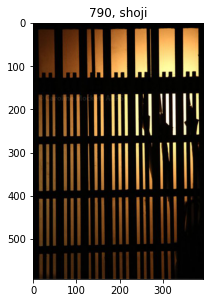

In [ ]:
plt.figure(figsize=(16,16))

def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)
  
for c in range(3):
    image_path = random.choice(all_image_paths)
    
    # 이미지 표시
    plt.subplot(3,2,c*2+1)
    plt.imshow(plt.imread(image_path))
    idx = int(image_path.split('/')[-2]) + 1
    plt.title(str(idx) + ', ' + label_text[idx])
    word = wordnet.synset_from_pos_and_offset('n',int(image_path.split('/')[-2][1:]))
    word = word.name().split('.')[0].replace('-','').replace('_','').replace(' ','')
    idx = label_text.index(word)
    plt.title(str(idx) + ', ' + label_text[idx])
    plt.axis('off')
    
    # 예측값 표시
    plt.subplot(3,2,c*2+2)
    img = cv2.imread(image_path)
    img = cv2.resize(img, dsize=(224, 224))
    img = img / 255.0
    img = np.expand_dims(img, axis=0)
    
    # MobileNet을 이용한 예측
    logits = model.predict(img)[0]
    prediction = softmax(logits)
    
    # 가장 높은 확률의 예측값 5개를 뽑음
    top_5_predict = prediction.argsort()[::-1][:5]
    labels = [label_text[index] for index in top_5_predict]
    color = ['gray'] * 5
    if idx in top_5_predict:
        color[top_5_predict.tolist().index(idx)] = 'green'
    color = color[::-1]
    plt.barh(range(5), prediction[top_5_predict][::-1] * 100, color=color)
    plt.yticks(range(5), labels[::-1])    

#8.2 transfer learning



전이 학습은 미리 훈련된 모델을 다른 작업에 사용하기 위해 추가적인 학습을 시키는 것 입니다. 데이터에서 유의미한 특징을 뽑아내거나 모델의 일부를 재학습 시키는데 사용합니다.

## 8.2.1 모델의 일부를 재학습시키기

- 미리 훈련된 CNN을 불러올 때, **가장 마지막의 Dense layer를 제외**한다(softmax 함수로 실제 분류 작업을 수행).
    - 그리고 새로운 분류 작업을 위한 레이어를 추가하거나, 좀 더 복잡한 분류 작업을 위해 여러 개의 Dense layer와 dropout layer를 추가.
    - 마지막에 추가되는 layer의 뉴런 수는 분류 작업의 범주 수
- **네트워크 훈련**시킴
    - 새로 추가된 레이어의 가중치만 훈련시킬 수도 있고 미리 훈련된 모델의 일부 레이어를 훈련시킬 수도 있음
    - 얼린다(freeze) : 훈련하지 않는 레이어
    - 레이어를 얼마나 얼릴지는 새로운 작업을 위한 데이터 양에 의해 결정 → 새로운 작업을 위한 데이터 양이 많을수록 기존에 훈련된 데이터와 차이가 많아져서 다시 학습시켜야 하는 양이 많아지기 때문에 얼리는 레이어의 양을 줄임

### <전이 학습 예제> : Dogs Dataset

: 2만여 개의 사진, 120가지 견종에 대한 라벨로 되어있습니다. kaggle dataset을 이용하겠습니다.

In [1]:
#kaggle API installation
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


kaggle 홈페이지에서 새로운 API Toekn을 생성합니다.

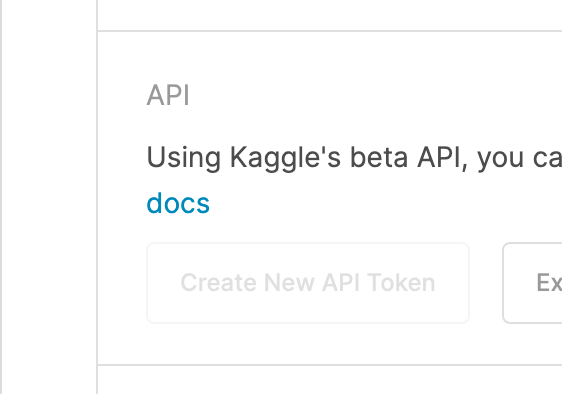

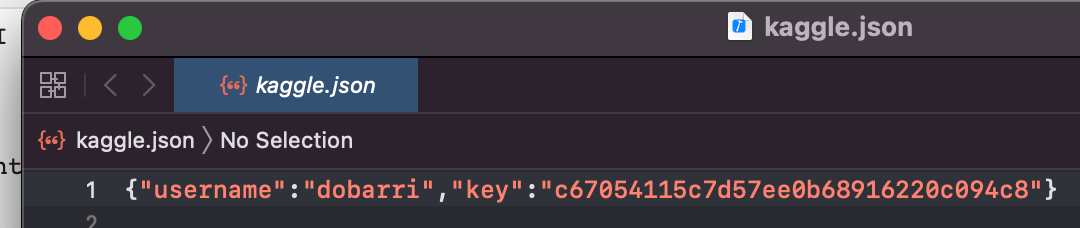

In [2]:
#Stanford Dog Dataset 불러오기

#파일구조가 변경되어 링크에서 파일을 직접 가져와야한다고 합니다.
import tensorflow as tf

tf.keras.utils.get_file('/content/labels.csv', 'http://bit.ly/2GDxsYS')
tf.keras.utils.get_file('/content/sample_submission.csv', 'http://bit.ly/2GGnMNd')
tf.keras.utils.get_file('/content/train.zip', 'http://bit.ly/31nIyel')
tf.keras.utils.get_file('/content/test.zip', 'http://bit.ly/2GHEsnO')

import os
os.environ['KAGGLE_USERNAME'] = 'dobarri' # 독자의 캐글 ID
os.environ['KAGGLE_KEY'] = 'c67054115c7d57ee0b68916220c094c8' # 독자의 캐글 API Token

파일 압축을 풀어줍니다.


In [9]:
!unzip train.zip
!unzip labels.csv.zip

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: train/83bcff6b55ee179a7c123fa6103c377a.jpg  
  inflating: train/83be6d622ab74a5e7e08b53eb8fd566a.jpg  
  inflating: train/83c2d7419b0429b9fe953bc1b6cddbec.jpg  
  inflating: train/83cf7d7cd2a759a93e2ffd95bea9c6fb.jpg  
  inflating: train/83d405858f0931722ef21e8ac0adee4d.jpg  
  inflating: train/83d4125a4c3c7dc5956563276cb1cd74.jpg  
  inflating: train/83f0bb565b2186dbcc6a9d009cb26ff2.jpg  
  inflating: train/83fad0718581a696132c96c166472627.jpg  
  inflating: train/83fbbcc9a612e3f712b1ba199da61f20.jpg  
  inflating: train/8403d8936430c2f05ab7d74d23c2c0cb.jpg  
  inflating: train/8406d837b2d7fac1c3cd621abb4c4f9e.jpg  
  inflating: train/840b67d26e5e43f8eb6430f62d4ba1ac.jpg  
  inflating: train/840db91ba4600148f3dcb06ec419b421.jpg  
  inflating: train/840dbad5a691c22611d85b2488bf4cbb.jpg  
  inflating: train/8410ced9ebc1759a7ebce5c42bfb5222.jpg  
  inflating: train/841463629c4833816e216cbb041c2778.jpg  
  inflating: train/8429dcca4ae91c4e0

정답 라벨을 담고있는 label.csv파일의 내용을 살펴보겠습니다.


In [3]:
import pandas as pd

label_text = pd.read_csv('labels.csv')
print(label_text.head())

                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever


id에는 파일명이 있고, breed에는 사진이 어떤 견종인지 분류되어 있습니다.

좀 더 요약된 정보를 확인하기 위해 info()함수를 사용합니다.

In [4]:
label_text.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10222 entries, 0 to 10221
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      10222 non-null  object
 1   breed   10222 non-null  object
dtypes: object(2)
memory usage: 159.8+ KB


train data에 10222장의 사진이 있는 것을 확인할 수 있습니다.이 사진들을 몇 개의 견종으로 분류할 수 있는지 알아보기 위해 nunique()함수를 사용합니다.

In [5]:
label_text['breed'].nunique()

120

120견종이 있으므로 이 train data에는 모든 견종이 다 존재한다고 생각할 수 있습니다.

실제 어떤 사진들로 구성되어 있는지 출력해보겠습니다.


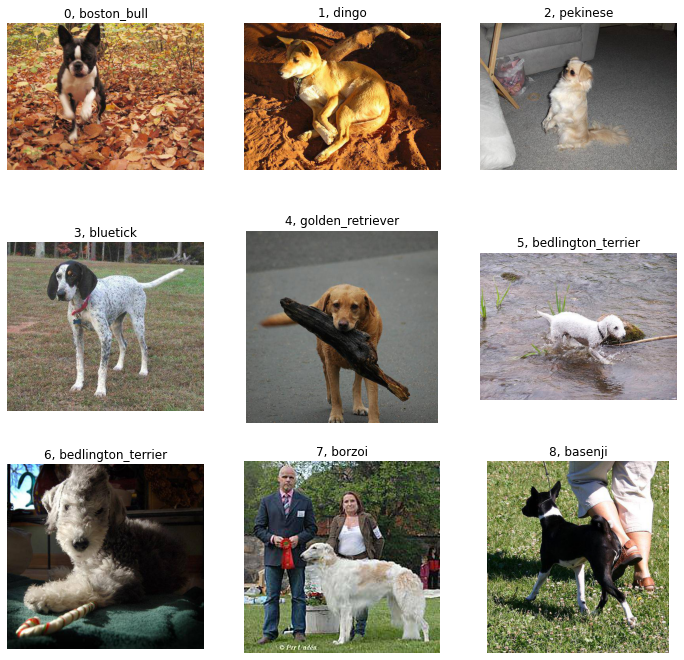

In [5]:
import PIL.Image as Image
import matplotlib.pyplot as plt

plt.figure(figsize=(12,12))
for c in range(9):
    image_id = label_text.loc[c, 'id']
    plt.subplot(3,3,c+1)
    plt.imshow(plt.imread('/content/train/' + image_id + '.jpg'))
    plt.title(str(c) + ', ' + label_text.loc[c, 'breed'])
    plt.axis('off')
plt.show()

우선 전이학습을 사용하기전에 MobileNet V2의 모든 레이어의 가중치를 초기화한 상태에서 학습을 시켜보겠습니다.

In [6]:
from tensorflow.keras.applications import MobileNetV2
mobilev2 = MobileNetV2()

In [7]:
# MobileNet V2의 가중치 초기화
import numpy as np

for layer in mobilev2.layers[:-1]:
    layer.trainable = True
    
for layer in mobilev2.layers[:-1]: 
    if 'kernel' in layer.__dict__:
        kernel_shape = np.array(layer.get_weights()).shape
        # weight를 평균이 0, 표준편차가 1인 random 변수로 초기화
        layer.set_weights(tf.random.normal(kernel_shape, 0, 1))

모든 layer의 trainable을 True로 해주어 학습이 가능하도록 해줍니다.

그리고 마지막 레이어인 Dense layer는 사용하지 않을 것이므로 제거해줍니다.

MobileNet V2에 bias는 존재하기 않기 때문에 kernel(weight)가 있는지만 확인한 후, 존재하면 랜덤한 값으로 초기화해줍니다.

In [ ]:
import cv2

train_X = []
for i in range(len(label_text)):
    img = cv2.imread('/content/train/' + label_text['id'][i] + '.jpg')
    img = cv2.resize(img, dsize=(224, 224))
    img = img / 255.0
    train_X.append(img)
train_X = np.array(train_X)
print(train_X.shape)
print(train_X.size * train_X.itemsize, ' bytes')

In [ ]:
# train 라벨 데이터
unique_Y = label_text['breed'].unique().tolist()
train_Y = [unique_Y.index(breed) for breed in label_text['breed']]
train_Y = np.array(train_Y)

print(train_Y[:10])
print(train_Y[-10:])

라벨데이터가 텍스트로 되어 있으므로 숫자로 바꿔줍니다. 

unique()함수를 이용해 겹치지 않는 유일한 원소들을 구하고 그것을 numpy array에서 tolist()함수로 python list로 변환해주고 학습을 위해 다시 numpy array로 만듭니다.

In [ ]:
# model 정의
x = mobilev2.layers[-2].output
predictions = tf.keras.layers.Dense(120, activation='softmax')(x)
model = tf.keras.Model(inputs=mobilev2.input, outputs=predictions)

model.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

- x변수에 마지막에서 2번째의 ouptut 저장하고 120개 뉴런가지는 새로운 레이어 만듬 → 마지막 레이어 제외하기 위해
- **함수형(functional) API**. → layer를 함수처럼 사용하는 구문
    - 입력부터 출력까지 일직선 구조이면 Sequential 모델 사용해도 되지만, 그렇지 않으면 함수형 모델을 사용해 model의 입력, 출력 구조 정의해야한다.
- tf.keras.Model() : 함수형 모델을 정의하기 위해 연결에 필요한 모든 layer를 준비하고 Model안에 inputs, outputs 인수에 입력해주면 tf.keras가 그 사이의 연결을 알아서 찾아 모델을 만든다.

이제 모델을 학습시키겠습니다.

In [ ]:
history = model.fit(train_X, train_Y, epochs=10, validation_split=0.25, batch_size=32)

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'], 'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], 'g-', label='accuracy')
plt.plot(history.history['val_accuracy'], 'k--', label='val_accuracy')
plt.xlabel('Epoch')
plt.ylim(0, 0.1)
plt.legend()

plt.show()

제대로 실행되었다면 val_loss가 좋지 않은 결과를 나타냅니다.

120개 견종 중 아무거나 하나 선택한다면 정답일 확률이 0.83%일텐데, 거의 이것과 비슷한 accuracy를 보입니다.

이제 같은 네트워크로 transfer learning을 해보겠습니다.

기존의 가중치는 그대로 사용하고 일부 레이어의 가중치를 고정시킨 상태로 학습하겠습니다.

In [ ]:
from tensorflow.keras.applications import MobileNetV2
mobilev2 = MobileNetV2()

x = mobilev2.layers[-2].output
predictions = tf.keras.layers.Dense(120, activation='softmax')(x)
model = tf.keras.Model(inputs=mobilev2.input, outputs=predictions)

# 뒤에서 20개까지의 레이어는 훈련 가능, 나머지는 가중치 고정
for layer in model.layers[:-20]:
    layer.trainable = False
for layer in model.layers[-20:]:
    layer.trainable = True

model.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

- 뒤에서 20개 레이어의 가중치만 훈련 가능하게 함. summary()보면 훈련 가능한 param과 훈련 불가능한 param이 비슷한 것을 알 수 있습니다.
- 데이터셋이 적을때는 overfitting 방지하기 위해서 **적은 layer만 훈련하고 늘려가는게 좋습니다.**
- 뒤에 layer일수록 구체적인 feature에 대해 학습되어있으므로 **뒤에 layer부터 다시 학습**시키는 것이 좋습니다.

In [ ]:
# 8.22 모델 학습 및 결과 확인
history = model.fit(train_X, train_Y, epochs=10, validation_split=0.25, batch_size=32)

import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'], 'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], 'g-', label='accuracy')
plt.plot(history.history['val_accuracy'], 'k--', label='val_accuracy')
plt.xlabel('Epoch')
plt.ylim(0.3, 1)
plt.legend()

plt.show()

같은 네트워크 구조를 사용했지만 val_accuracy가 훨씬 좋은 성능을 보인다고 합니다. 학습시킬 가중치 숫자도 줄어들어 학습 속도도 1/3정도 되었다고 합니다. 

결론적으로 정리를 해보면, 적은 양의 데이터를 가지고 있을 때 미리 훈련된 모델의 가중치를 사용해 모델의 성능을 높일 수 있습니다.